In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install pytorch_lightning

### Importing Packages 

In [142]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import h5py
import numpy as np
import math
# from rpn import *
# from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import partial
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
# from utils import *
import matplotlib.pyplot as plt
# from rpn import *
import matplotlib.patches as patches
from pytorch_lightning.core.datamodule import LightningDataModule
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import pytorch_lightning as pl

# !cd /content/drive/MyDrive/CIS680_HW4
# from dataset import *

### Utils functions

In [ ]:
# utils.py

def MultiApply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
  
    return tuple(map(list, zip(*map_results)))

# This function computes the IOU between two set of boxes
def IOU(output, target):
    ##################################
    #TODO compute the IOU between the boxA, boxB boxes
    ##################################
  
    output_box_x1 = output[:, 0] - output[:, 2] / 2
    output_box_y1 = output[:, 1] - output[:, 3] / 2
    output_box_x2 = output[:, 0] + output[:, 2] / 2
    output_box_y2 = output[:, 1] + output[:, 3] / 2
    target_box_x1 = target[:, 0] - target[:, 2] / 2
    target_box_y1 = target[:, 1] - target[:, 3] / 2
    target_box_x2 = target[:, 0] + target[:, 2] / 2
    target_box_y2 = target[:, 1] + target[:, 3] / 2

    x1 = torch.max(output_box_x1, target_box_x1)
    y1 = torch.max(output_box_y1, target_box_y1)
    x2 = torch.min(output_box_x2, target_box_x2)
    y2 = torch.min(output_box_y2, target_box_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    # output_box_area = abs((output_box_x2 - output_box_x1) * (output_box_y2 - output_box_y1))
    # target_box_area = abs((target_box_x2 - target_box_x1) * (target_box_y2 - target_box_y1))
    output_box_area = target[:, 2] * target[:, 3] 
    target_box_area = output[:, 2] * output[:, 3] 

    return intersection / (output_box_area + target_box_area - intersection + 1e-6)


# This function flattens the output of the network and the corresponding anchors 
# in the sense that it concatenates  the outputs and the anchors from all the grid cells
# from all the images into 2D matrices
# Each row of the 2D matrices corresponds to a specific anchor/grid cell
# Input:
#       out_r: (bz,4,grid_size[0],grid_size[1])
#       out_c: (bz,1,grid_size[0],grid_size[1])
#       anchors: (bz,grid_size[0],grid_size[1],4)
# Output:
#       flatten_regr: (bz*grid_size[0]*grid_size[1],4)
#       flatten_clas: (bz*grid_size[0]*grid_size[1])
#       flatten_anchors: (bz*grid_size[0]*grid_size[1],4)
def output_flattening(out_r,out_c,anchors):
    #######################################
    # TODO flatten the output tensors and anchors
    #######################################
    out_r = out_r.permute((0,2,3,1))
    flatten_regr = out_r.reshape((-1, out_r.shape[3]))
    out_c = out_c.permute((0,2,3,1))
    flatten_clas = out_c.reshape((-1, out_c.shape[3]))
    flatten_clas = flatten_clas.squeeze(-1)
    # anchors = anchors.permute((0,2,3,1))
    # print('anchors.shape: ', anchors.shape)
    flatten_anchors = anchors.reshape((-1, anchors.shape[2]))
    # print('flatten_anchors.shape: ', flatten_anchors.shape)

    return flatten_regr, flatten_clas, flatten_anchors




# This function decodes the output that is given in the encoded format (defined in the handout)
# into box coordinates where it returns the upper left and lower right corner of the proposed box
# Input:
#       flatten_out: (total_number_of_anchors*bz,4)
#       flatten_anchors: (total_number_of_anchors*bz,4)
# Output:
#       box: (total_number_of_anchors*bz,4)
def output_decoding(out,anchors, device='cpu'):
    #######################################
    # TODO decode the output
    #######################################
    # print('flatten_out.shape: ', flatten_out.shape)
    # print('flatten_anchors.shape: ', flatten_anchors.shape)
    anchors = anchors.cpu()
    box = torch.zeros(out.shape)
    # box[:, 0] = (out[:, 0] * flatten_anchors[:, 2]) + flatten_anchors[:,0]
    # box[:, 1] = (out[:, 1] * flatten_anchors[:, 3]) + flatten_anchors[:,1]
    # box[:, 2] = torch.exp(flatten_out[:, 2]) * flatten_anchors[:, 2]
    # box[:, 3] = torch.exp(flatten_out[:, 3]) * flatten_anchors[:, 3]

    box[0,:,:] = out[0,:,:]*anchors[:,:,2] + anchors[:,:,0]
    box[1,:,:] = out[1,:,:]*anchors[:,:,3] + anchors[:,:,1]
    box[2,:,:] = torch.exp(out[2,:,:])*anchors[:,:,2]
    box[3,:,:] = torch.exp(out[3,:,:])*anchors[:,:,3]
    
    return box

### DataLoader Creation

In [ ]:
def load_data(paths):
  images_file = h5py.File(paths[0],'r') 
  masks_file = h5py.File(paths[1],'r')
  

  images = np.array(images_file['data'])
  masks = np.array(masks_file['data'])
  bboxes = np.load(paths[3], allow_pickle=True)
  labels = np.load(paths[2], allow_pickle=True)

  label_based_masks = []
  cur_pointer = 0
  for label in labels:
    cur_mask = np.empty((len(label), 300, 400))

    for i in range(len(label)):
      cur_mask[i] = masks[cur_pointer]
      cur_pointer += 1
    label_based_masks.append(cur_mask)

  label_based_masks = np.array(label_based_masks)

  return images, label_based_masks, labels, bboxes

def collate_fn(batch):
    images, labels, masks, bounding_boxes, indices = list(zip(*batch))
    # bounding_boxes = torch.stack(bounding_boxes)
    # print('bbox in collate:', bounding_boxes)
    # print(bounding_boxes.shape)
    return torch.stack(images), labels, masks, bounding_boxes, indices

class BuildDataset(Dataset):
    def __init__(self, path, image_transform=None, mask_transform = None):
        #############################################
        # TODO Initialize  Dataset
        #############################################
        self.images, self.masks, self.labels, self.bboxes = load_data(path)

        self.image_transform = image_transform
        self.mask_transform = mask_transform

    # In this function for given index we rescale the image and the corresponding  masks, boxes
    # and we return them as output
    # output:
        # transed_img
        # label
        # transed_mask
        # transed_bbox
        # index
    def __getitem__(self, idx):
        ################################
        # TODO return transformed images,labels,masks,boxes,index
        ################################
        image = self.images[idx].astype('uint8').transpose(1,2,0)
        # image = self.images[idx]
        label = self.labels[idx].astype('float32')
        # num_labels = len(label)
        mask = torch.tensor(self.masks[idx].astype('float64'))
        bbox = self.bboxes[idx].astype('float32')
        # print(image.shape)
        # print(mask.shape)

        if self.image_transform:
          image = self.image_transform(image)
          mask = self.mask_transform(mask)
          x_scale = 800.0 / 300.0
          y_scale = 1088.0 / 400.0
          for i, box in enumerate(bbox):
            bbox[i][0] = box[0] * x_scale
            bbox[i][1] = box[1] * y_scale
            bbox[i][2] = box[2] * x_scale
            bbox[i][3] = box[3] * y_scale
        
        bbox = torch.tensor(bbox, device = device)
        # print('bbox in getitem: ', bbox)
        # print(bbox.shape)
        assert image.shape == (3,800,1088)
        assert bbox.shape[0] == mask.shape[0]
        
        return image, label, mask, bbox, idx

    # This function preprocess the given image, mask, box by rescaling them appropriately
    # output:
    #        img: (3,800,1088)
    #        mask: (n_box,800,1088)
    #        box: (n_box,4)
    # def pre_process_batch(self, img, mask, bbox):
    #     #######################################
    #     # TODO apply the correct transformation to the images,masks,boxes
    #     ######################################

    #     assert img.squeeze(0).shape == (3, 800, 1088)
    #     assert bbox.shape[0] == mask.squeeze(0).shape[0]

    #     return img.squeeze(0), mask.squeeze(0), bbox
    
    def __len__(self):
        return self.labels.shape[0]


class BuildDataLoader(LightningDataModule):
    def __init__(self, dataset, batch_size=32):
        super().__init__()

        self.dataset = dataset
        self.batch_size = batch_size

        return

    def setup(self, stage=None):
        # val_split = int(0.05 * len(self.dataset))
        test_split = int(0.2 * len(self.dataset))  # 5% of data to be used as validation set
        self.train_data, self.test_data = random_split(self.dataset, [len(self.dataset)-test_split, test_split])

        return
        

    def train_dataloader(self):
        
        # Generating train_dataloader
        return DataLoader(self.train_data, batch_size = self.batch_size, collate_fn=collate_fn, shuffle = True)
    
    def predict_dataloader(self):
        
        # Generating val_dataloader
        return DataLoader(self.test_data, batch_size = 1, collate_fn=collate_fn, shuffle = False)



 
  
 

### RPN Network Initialisation

In [ ]:
import copy

class RPNHead(pl.LightningModule):

    def __init__(self,  device='cuda:0', anchors_param=dict(ratio=0.8,scale= 256, grid_size=(50, 68), stride=16)):
        # Initialize the backbone, intermediate layer clasifier and regressor heads of the RPN
        super(RPNHead,self).__init__()

        # self.device=device
        # TODO Define Backbone
        self.backbone = nn.Sequential(
                          nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,padding='same'),
                          nn.BatchNorm2d(num_features=16),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=2,stride=2, padding=0),
                          nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,padding='same'),
                          nn.BatchNorm2d(num_features=32),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=2,stride=2, padding=0),
                          nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding='same'),
                          nn.BatchNorm2d(num_features=64),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=2,stride=2, padding=0),
                          nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding='same'),
                          nn.BatchNorm2d(num_features=128),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=2,stride=2, padding=0),
                          nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,padding='same'),
                          nn.BatchNorm2d(num_features=256),
                          nn.ReLU()
                          )

        # TODO  Define Intermediate Layer
        self.intermediate_layer = nn.Sequential(
                                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding='same'),
                                    nn.BatchNorm2d(num_features=256),
                                    nn.ReLU()
                                  )

        # TODO  Define Proposal Classifier Head
        self.classifier_head = nn.Sequential(
                                  nn.Conv2d(in_channels=256,out_channels=1,kernel_size=1,padding='same'),
                                  nn.Sigmoid()
                               )
        # TODO Define Proposal Regressor Head
        self.proposal_regressor_head = nn.Conv2d(in_channels=256,out_channels=4,kernel_size=1,padding='same')
                                

        #  find anchors
        self.anchors_param=anchors_param
        self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
        self.ground_dict={}
        self.image_size = (800, 1088)
        self.train_losses = []


    # Forward  the input through the backbone the intermediate layer and the RPN heads
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       logits: (bz,1,grid_size[0],grid_size[1])}
    #       bbox_regs: (bz,4, grid_size[0],grid_size[1])}
    def forward(self, X):

        #TODO forward through the Backbone

        X =self.backbone(X)

        #TODO forward through the Intermediate layer
        X = self.intermediate_layer(X)


        #TODO forward through the Classifier Head
        logits = self.classifier_head(X)


        #TODO forward through the Regressor Head
        bbox_regs = self.proposal_regressor_head(X)

        assert logits.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        # print(bbox_regs.shape)
        # print('bbox_regs.shape[1:4]: ', bbox_regs.shape[1:4])
        assert bbox_regs.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return logits, bbox_regs




    # Forward input batch through the backbone
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       X: (bz,256,grid_size[0],grid_size[1])
    def forward_backbone(self,X):
        #####################################
        # TODO forward through the backbone
        #####################################
        X = self.backbone(X)
        assert X.shape[1:4]==(256,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return X



    # This function creates the anchor boxes
    # Output:
    #       anchors: (grid_size[0],grid_size[1],4)
    
    def create_anchors(self, aspect_ratio, scale, grid_sizes, stride = 1):
        ######################################
        # TODO create anchors
        ######################################
        w = scale * math.sqrt(aspect_ratio)
        h = scale / math.sqrt(aspect_ratio)
        anchors = torch.zeros((grid_sizes[0] , grid_sizes[1],4))
        y_c, x_c= torch.meshgrid(torch.arange(stride/2,float(grid_sizes[0]*stride), step =stride), torch.arange(stride/2,float(grid_sizes[1]*stride), step =stride))
        anchors[:,:,0] = x_c
        anchors[:,:,1] = y_c
        anchors[:,:,2] = w*torch.ones(grid_sizes)
        anchors[:,:,3] = h*torch.ones(grid_sizes)

        assert anchors.shape == (grid_sizes[0] , grid_sizes[1],4)

        return anchors.to(device)


    def get_anchors(self):
        return self.anchors

    def create_batch_truth(self,bboxes_list,indexes,image_shape):
        #####################################
        # TODO create ground truth for a batch of images
        #####################################
        ground_clas = []
        ground_coord = []
        for i in range(len(indexes)):
          cur_ground_clas, cur_ground_coord = self.create_ground_truth(bboxes_list[i], indexes[i], self.anchors_param['grid_size'], self.anchors, image_shape)
          ground_clas.append(cur_ground_clas)
          ground_coord.append(cur_ground_coord)

        ground_clas = torch.cat([x.unsqueeze(0) for x in ground_clas], axis=0)
        ground_coord = torch.cat([x.unsqueeze(0) for x in ground_coord], axis=0)

        assert ground_clas.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        assert ground_coord.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return ground_clas, ground_coord



    # This function creates the ground truth for one image
    # It also caches the ground truth for the image using its index
    # Input:
    #       bboxes:      (n_boxes,4)
    #       index:       scalar (the index of the image in the total dataset used for caching)
    #       grid_size:   tuple:len(2)
    #       anchors:     (grid_size[0],grid_size[1],4)
    # Output:
    #       ground_clas:  (1,grid_size[0],grid_size[1])
    #       ground_coord: (4,grid_size[0],grid_size[1])
    
    def create_ground_truth(self, bboxes_original, index, grid_size, anchors, image_size):
        key = str(index)
        if key in self.ground_dict:
            groundt, ground_coord = self.ground_dict[key]
            return groundt, ground_coord

        #####################################################
        # TODO create ground truth for a single image
        #####################################################

        bboxes = copy.deepcopy(bboxes_original)

        bboxes[:,0] = (bboxes_original[:,0] + bboxes_original[:,2])/2
        bboxes[:,1] = (bboxes_original[:,1] + bboxes_original[:,3])/2
        bboxes[:,2] = bboxes_original[:,2] - bboxes_original[:,0]
        bboxes[:,3] = bboxes_original[:,3] - bboxes_original[:,1]

        
        ground_clas = torch.ones((1, grid_size[0], grid_size[1]), device=device) * -1
        ground_coord = torch.zeros((4, grid_size[0], grid_size[1]), device=device)

        flattened_anchors = anchors.reshape([anchors.shape[0]* anchors.shape[1], -1])
        num_final_anchors = flattened_anchors.shape[0]


        non_cross_boundary_mask = torch.logical_and(torch.logical_and((flattened_anchors[:,0] - flattened_anchors[:,2]/2) >= 0, \
                                                            (flattened_anchors[:,0] + flattened_anchors[:,2]/2) < self.image_size[1]), \
                                                    torch.logical_and((flattened_anchors[:,1] - flattened_anchors[:,3]/2) >= 0, \
                                                            (flattened_anchors[:,1] + flattened_anchors[:,3]/2) < self.image_size[0])).reshape(grid_size[0], grid_size[1])
        

        bbox_IOUs = torch.zeros([len(bboxes), grid_size[0], grid_size[1]])
        neg_gridcells = torch.ones((grid_size[0]*grid_size[1]), dtype=bool, device = device)
        for i, bbox in enumerate(bboxes):
          replicated_bbox = bbox.repeat((num_final_anchors, 1))
          cur_IOU = IOU(flattened_anchors.to(device), replicated_bbox.to(device)).reshape(grid_size[0], grid_size[1])
          bbox_IOUs[i] = cur_IOU

        pos_gridcells = torch.zeros_like(bbox_IOUs, dtype = torch.bool)
        neg_gridcells = torch.zeros_like(bbox_IOUs, dtype = torch.bool)

        for i in range(bbox_IOUs.shape[0]):
          iou_max = torch.max(bbox_IOUs[i])
          pos_gridcells[i] =  torch.logical_or((bbox_IOUs[i] >= 0.99*iou_max), (bbox_IOUs[i] > 0.7))
          neg_gridcells[i] = torch.logical_and(torch.logical_not(pos_gridcells[i]), (bbox_IOUs[i] < 0.3))
        pos_grids = (torch.sum(pos_gridcells, dim= 0) > 0)
        neg_grids = (torch.sum(neg_gridcells, dim= 0) == bbox_IOUs.shape[0])
        ground_clas[0, pos_grids] = 1
        ground_clas[0, neg_grids] = 0
        ground_clas[0, torch.logical_not(non_cross_boundary_mask)] = -1

        iou_m, iou_m_idx = torch.max(bbox_IOUs, dim = 0)
        ground_coord[:, pos_grids] = bboxes[iou_m_idx[pos_grids], :].T

        ground_coord[0, :, :] = ((ground_coord[0, :, :]-anchors[:,:, 0])/anchors[:, :, 2])
        ground_coord[1, :, :] = ((ground_coord[1, :, :]-anchors[:,:, 1])/anchors[:, :, 3])
        ground_coord[2, :, :] = (torch.log(ground_coord[2, :, :] / anchors[:, :, 2]))
        ground_coord[3, :, :] = (torch.log(ground_coord[3, :, :] / anchors[:, :, 3]))
        
        
        self.ground_dict[key] = (ground_clas, ground_coord)

        assert ground_clas.shape==(1,grid_size[0],grid_size[1])
        assert ground_coord.shape==(4,grid_size[0],grid_size[1])

        return ground_clas, ground_coord



    # Compute the loss of the classifier
    # Input:
    #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
    #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels
    def loss_class(self,p_out,n_out):

        #torch.nn.BCELoss()
        # TODO compute classifier's loss
        target = torch.cat((torch.ones(p_out.shape[0]).to(device), torch.zeros(n_out.shape[0]).to(device)), 0)
        output = torch.cat((p_out, n_out), 0)
        loss_classifier = torch.nn.BCELoss(reduction = 'mean')
        loss = loss_classifier(output, target)


        return loss



    # Compute the loss of the regressor
    # Input:
    #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
    #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
    def loss_reg(self,pos_target_coord,pos_out_r):
            #torch.nn.SmoothL1Loss()
            # TODO compute regressor's loss
            loss_regressor = torch.nn.SmoothL1Loss(reduction = 'sum')
            loss = loss_regressor(pos_out_r,pos_target_coord)

            return loss


    # Compute the total loss
    # Input:
    #       clas_out: (bz,1,grid_size[0],grid_size[1])
    #       regr_out: (bz,4,grid_size[0],grid_size[1])
    #       targ_clas:(bz,1,grid_size[0],grid_size[1])
    #       targ_regr:(bz,4,grid_size[0],grid_size[1])
    #       l: lambda constant to weight between the two losses
    #       effective_batch: the number of anchors in the effective batch (M in the handout)
    def compute_loss(self,clas_out,regr_out,targ_clas,targ_regr, l=5, effective_batch=50):
            #############################
            # TODO compute the total loss
            #############################
            pos_n = min((targ_clas == 1).sum(), effective_batch/2)

            # neg_n = (targ_clas == 0).sum()
            

            p_out = clas_out[targ_clas == 1][np.random.choice(int(pos_n), effective_batch//2, replace=False)]
            n_out = clas_out[targ_clas == 0][np.random.choice(effective_batch - int(pos_n), effective_batch//2, replace=False)]
            
            loss_c = self.loss_class(p_out, n_out)

            regr_out_ = regr_out.permute(0,2,3,1)
            regr_out_flat = regr_out_.flatten(start_dim = 0, end_dim = 2)

            targ_regr_ = targ_regr.permute(0,2,3,1)
            targ_regr_flat = targ_regr_.flatten(start_dim = 0, end_dim = 2)

            regr_pos = regr_out_flat[targ_clas.flatten() == 1,:][np.random.choice(int(pos_n), effective_batch//2, replace=False),:]
            targ_regr_pos = targ_regr_flat[targ_clas.flatten() == 1,:][np.random.choice(int(pos_n), effective_batch//2, replace=False),:]
            loss_r = self.loss_reg(targ_regr_pos, regr_pos)/effective_batch

            loss = loss_c + l*loss_r

            return loss, loss_c, loss_r

    def training_step(self, batch, batch_idx):
      # print('---------- getting batch -------')
      images, labels, masks, bboxes, indices = batch
      # print('---------- getting model out -------')
      logits, bbox_regs = self.forward(images.to(device))
      # print('---------- creating groundtruth -------')
      ground_clas, ground_coord = self.create_batch_truth(bboxes, indices, self.image_size)
      # print('---------- computing loss -------')
      loss, loss_c, loss_r = self.compute_loss(logits, bbox_regs, ground_clas, ground_coord)
      # print('---------- all training steps done -------')
      
      self.log("train_class_loss", loss_c, prog_bar=True)
      self.log("train_regr_loss", loss_r, prog_bar=True)
      self.log("train_loss", loss, prog_bar=True)

      return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
    
    
    def training_epoch_end(self, outputs):
      self.train_losses.append((torch.tensor([output["loss"] for output in outputs]).mean().item(),\
                                torch.tensor([output["loss_c"] for output in outputs]).mean().item(), \
                                torch.tensor([output["loss_r"] for output in outputs]).mean().item()))
    
    def configure_optimizers(self):
      optimizer = torch.optim.SGD(self.parameters(), lr=0.001, weight_decay = 5e-4)
      scheduler = {"scheduler": torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)}
      return {"optimizer": optimizer, 'lr_scheduler': scheduler}

    # Post process for the outputs for a batch of images
    # Input:
    #       out_c:  (bz,1,grid_size[0],grid_size[1])}
    #       out_r:  (bz,4,grid_size[0],grid_size[1])}
    #       IOU_thresh: scalar that is the IOU threshold for the NMS
    #       keep_num_preNMS: number of masks we will keep from each image before the NMS
    #       keep_num_postNMS: number of masks we will keep from each image after the NMS
    # Output:
    #       nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
    #       nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinates of the boxes that the NMS kept)
    def postprocess(self,image,out_c,out_r, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=10):
    ####################################
    # TODO postprocess a batch of images
    #####################################
      batch_size = out_c.shape[0]

      list_C = [out_c[i] for i in range(batch_size)]
      list_R = [out_r[i] for i in range(batch_size)]

      nms_clas_list, nms_prebox_list = MultiApply(self.postprocessImg, [image]*batch_size, list_C, list_R, [IOU_thresh]*batch_size, [keep_num_preNMS]*batch_size, [keep_num_postNMS]*batch_size)
          
      return nms_clas_list, nms_prebox_list



    # Post process the output for one image
    # Input:
    #      mat_clas: (1,grid_size[0],grid_size[1])}  (scores of the output boxes)
    #      mat_coord: (4,grid_size[0],grid_size[1])} (encoded coordinates of the output boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)
    def postprocessImg(self,image,mat_clas,mat_coord, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
    ######################################
    # TODO postprocess a single image
    #####################################
    # Decoding coordinates 
      mat_coord = output_decoding(mat_coord, self.anchors)
      cross_boundary_mask = torch.logical_and(torch.logical_and( (mat_coord[0,:,:] - (mat_coord[2,:,:]/2)) < 0 , \
                                                          (mat_coord[0,:,:] + (mat_coord[2,:,:]/2)) > self.image_size[1]), \
                                                torch.logical_and( (mat_coord[1,:,:] - (mat_coord[3,:,:]/2)) < 0 , \
                                                        (mat_coord[1,:,:] + (mat_coord[3,:,:]/2)) < self.image_size[0]) )
      mat_clas[0,cross_boundary_mask] = 0
      mat_clas = mat_clas.flatten()                                          
      sorted_scores, sorted_indices = torch.sort(mat_clas, descending = True) 
      coord = mat_coord.flatten(start_dim = 1)  

      pre_nms_indices = sorted_indices[0:keep_num_preNMS]
      pre_nms_coord = coord[:,pre_nms_indices].T
      pre_nms_scores = sorted_scores[pre_nms_indices] 

      plt.imshow(image.permute(1, 2, 0))
      plt.title('Pre-NMS predicted bounding boxes')
      boxes = pre_nms_coord.detach().numpy()

      for j in range(boxes.shape[0]):
        w = boxes[j,2]
        h = boxes[j,3]
        rect = Rectangle((boxes[j,0]-(w/2), boxes[j,1]-(h/2)), w, h, edgecolor='b', facecolor=None, fill=False)
        plt.gca().add_patch(rect)

      plt.show()

      if keep_num_postNMS > 0:
        post_nms_score, post_nms_box  = self.NMS(pre_nms_scores, pre_nms_coord, IOU_thresh)

        nms_clas = post_nms_score[0:keep_num_postNMS]
        nms_prebox = post_nms_box[0:keep_num_postNMS,:]

        positive_class = (nms_clas>0).sum().item()

        nms_clas = nms_clas[0:positive_class]
        nms_prebox = nms_prebox[0:positive_class,:]

        nms_clas_list = [nms_clas]
        nms_prebox_list = [nms_prebox]
        plt.imshow(image.permute(1, 2, 0))
        plt.title('Post-NMS predicted bounding boxes')
        boxes = nms_prebox.detach().numpy()
        for j in range(boxes.shape[0]):
          w = boxes[j,2]
          h = boxes[j,3]
          rect = Rectangle((boxes[j,0]-(w/2), boxes[j,1]-(h/2)), w, h, edgecolor='b', facecolor=None, fill=False)
          plt.gca().add_patch(rect)
        plt.show()

        return nms_clas[0:positive_class], nms_prebox[0:positive_class,:]
      else:
        return 0,0


    # Input:
    #       clas: (top_k_boxes) (scores of the top k boxes)
    #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4)
    def NMS(self,clas,prebox, thresh):
    ##################################
    # TODO perform NSM
    ##################################
    
      method= 'gauss'
      n = len(clas)
      gauss_sigma = 0.5

      x1 = prebox[:,0] - (prebox[:,2]/2).reshape(-1,1)
      y1 = prebox[:,1] - (prebox[:,3]/2).reshape(-1,1)
      x2 = prebox[:,0] + (prebox[:,2]/2).reshape(-1,1)
      y2 = prebox[:,1] + (prebox[:,3]/2).reshape(-1,1)

      x1_ = torch.max(x1,x1.T)
      y1_ = torch.max(y1,y1.T)
      x2_ = torch.min(x2,x2.T)
      y2_ = torch.min(y2,y2.T)

      intersection = (x2_ - x1_ + 1).clamp(0) * (y2_ - y1_ + 1).clamp(0)

      union = (x2 - x1 + 1) * (y2 - y1 + 1) + (x2.T - x1.T + 1) * (y2.T - y1.T + 1) - intersection

      ious = (intersection / union).triu(diagonal=1)

      ious_cmax = ious.max(0)[0].expand(n, n).T
      if method == 'gauss':
          decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
      else:
          decay = (1 - ious) / (1 - ious_cmax)
      decay  = decay.min(dim=0)[0]

      decay_clas = clas*decay

      sorted_decay_score, sorted_decay_idx = torch.sort(decay_clas,descending = True)
      
      nms_prebox = prebox[sorted_decay_idx,:]
      nms_clas = sorted_decay_score

      return nms_clas, nms_prebox



### Training

In [ ]:
# file path and make a list
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
imgs_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
batch_size = 16
num_epochs = 36
# train_size, test_size =  
# load the data into data.Dataset

image_transform = transforms.Compose([
                            transforms.ToTensor(),
                            # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                      transforms.Resize((800, 1066)),
                      transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                      transforms.Pad([11,0])
                      ])

mask_transform = transforms.Compose([       
                          transforms.Resize((800, 1066)),
                          transforms.Pad([11,0])
                          ])


COCOdata = BuildDataset(paths, image_transform, mask_transform)
# full_size = len(dataset)
# train_size = int(full_size * 0.8)
# test_size = full_size - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(COCOdata, [train_size, test_size])

COCODataLoader = BuildDataLoader(COCOdata, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))
model.to(device)
trainer = pl.Trainer(max_epochs=num_epochs, gpus=1, num_sanity_val_steps=0)
trainer.fit(model, COCODataLoader)
torch.save(model.state_dict(), 'rpn.pth')
np.save('train_losses.npy', model.train_losses)
# np.save('val_losses.npy', model.val_losses)

### Dataset Visualisation

Cats - Blue, Vehicle - Red, Person - Green


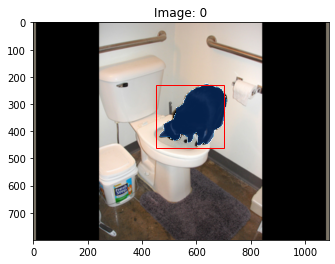

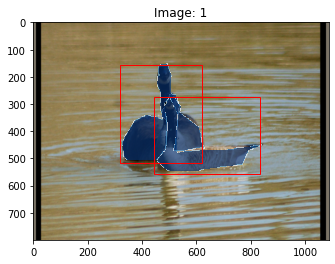

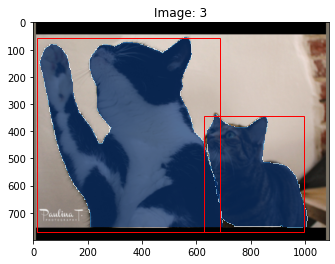

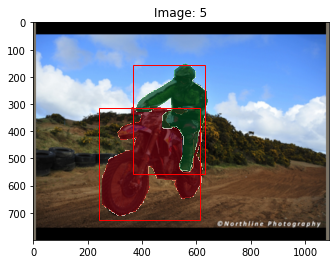

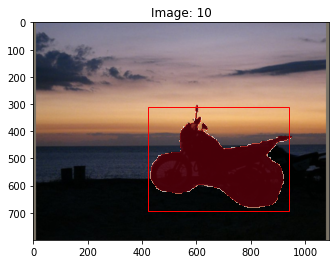

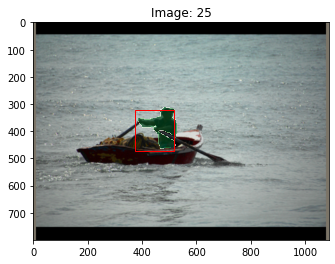

In [ ]:
import random
print('Cats - Blue, Vehicle - Red, Person - Green')
for j, idx in enumerate([0, 1, 3, 5, 10, 25]):
  image, label, mask, bbox, _ = COCOdata.__getitem__(idx)

  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  x = image * STD[:, None, None] + MEAN[:, None, None]

  plt.imshow(x.permute(1, 2, 0))
  label_to_color = {}
  label_to_color[1] = 'Reds'
  label_to_color[2] = 'Greens'
  label_to_color[3] = 'Blues'

  for i in range(mask.shape[0]):
    masked = np.ma.masked_where(mask[i] == 0, mask[i])
    plt.imshow(masked, cmap = label_to_color[int(label[i])], interpolation = 'none', alpha=0.7)
    bbox = bbox.cpu()
    box = Rectangle((bbox[i][0], bbox[i][1]), bbox[i][2] - bbox[i][0], bbox[i][3] - bbox[i][1],  linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(box)
  plt.title('Image: %d' %idx)
  plt.show()

### Histogram Plots

In [ ]:
import math
a = []
s = []
for i in range(3265):
  _,_,_,bboxes,_ = COCOdata.__getitem__(i)
  for bbox in bboxes:
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    a.append(w/h)
    s.append(math.sqrt(w*h))



In [ ]:
a = [i.cpu().numpy() for i in a]

### As we can see below from the two histograms the majority of bboxes aspect ratios lie in the range of [0.5, 0.8] and scale lies in the range of [250, 290]. So, we chose aspect ratio = 0.6 and scale = 256

(array([5.920e+02, 1.339e+03, 9.470e+02, 5.620e+02, 2.190e+02, 9.700e+01,
        3.900e+01, 2.100e+01, 1.400e+01, 5.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.09427009, 0.54495734, 0.99564457, 1.4463319 , 1.897019  ,
        2.3477063 , 2.7983935 , 3.249081  , 3.699768  , 4.1504555 ,
        4.6011424 , 5.05183   , 5.502517  , 5.953204  , 6.4038916 ,
        6.854579  , 7.305266  , 7.7559533 , 8.20664   , 8.657328  ,
        9.108015  ], dtype=float32),
 <a list of 20 Patch objects>)

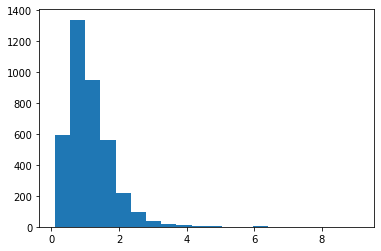

In [ ]:
plt.hist(a, density=False, bins=20)  


(array([106., 229., 244., 287., 322., 302., 288., 250., 274., 240., 226.,
        218., 191., 152., 132., 126., 100.,  70.,  59.,  27.]),
 array([ 88.32798265, 130.45460797, 172.58123329, 214.70785861,
        256.83448392, 298.96110924, 341.08773456, 383.21435988,
        425.3409852 , 467.46761051, 509.59423583, 551.72086115,
        593.84748647, 635.97411179, 678.1007371 , 720.22736242,
        762.35398774, 804.48061306, 846.60723837, 888.73386369,
        930.86048901]),
 <a list of 20 Patch objects>)

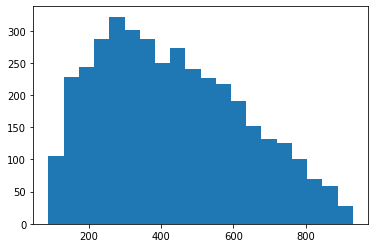

In [ ]:
plt.hist(s, density = False, bins = 20)

### Ground Truth Assignment Visualization

In [ ]:
def output_decoding_unflat(flatten_out,flatten_anchors, device='cpu'):
    #######################################
    # TODO decode the output
    #######################################
    # print('flatten_out.shape: ', flatten_out.shape)
    # print('flatten_anchors.shape: ', flatten_anchors.shape)
    flatten_anchors = flatten_anchors.cpu()

    box = torch.zeros(flatten_out.shape)
    flatten_out = flatten_out.cpu()
    box[:, 0] = (flatten_out[:, 0] * flatten_anchors[:, 2]) + flatten_anchors[:,0]
    box[:, 1] = (flatten_out[:, 1] * flatten_anchors[:, 3]) + flatten_anchors[:,1]
    box[:, 2] = torch.exp(flatten_out[:, 2]) * flatten_anchors[:, 2]
    box[:, 3] = torch.exp(flatten_out[:, 3]) * flatten_anchors[:, 3]

    # box[0,:,:] = out[0,:,:]*anchors[:,:,2] + anchors[:,:,0]
    # box[1,:,:] = out[1,:,:]*anchors[:,:,3] + anchors[:,:,1]
    # box[2,:,:] = torch.exp(out[2,:,:])*anchors[:,:,2]
    # box[3,:,:] = torch.exp(out[3,:,:])*anchors[:,:,3]
    
    return box

Cats - Blue, Vehicle - Red, Person - Green


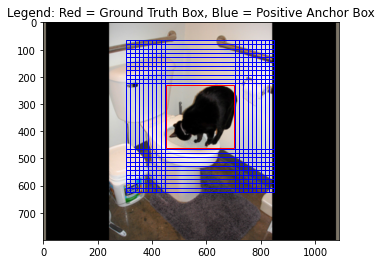

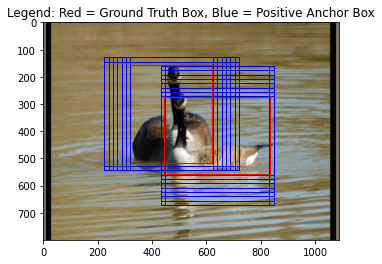

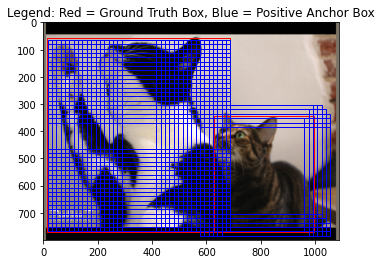

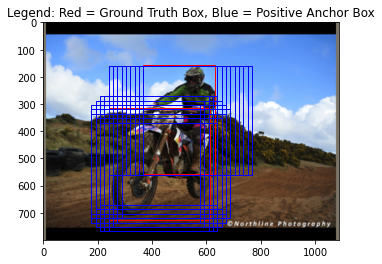

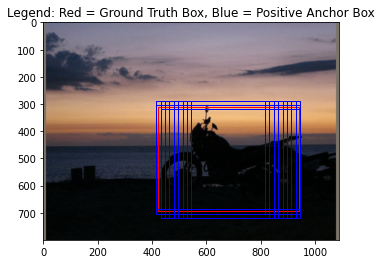

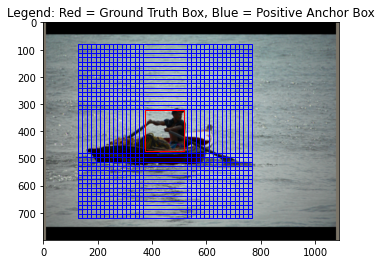

In [145]:
import random
image_size = (800, 1088)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))

print('Cats - Blue, Vehicle - Red, Person - Green')

for j, idx in enumerate([0, 1, 3, 5, 10, 25]):
  images, labels, masks, bboxes, indices = COCOdata.__getitem__(idx)
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  decoded_image = images * STD[:, None, None] + MEAN[:, None, None]

  plt.imshow(decoded_image.permute(1, 2, 0)) 
  
  ground_class, ground_coord = model.create_ground_truth(bboxes, indices, model.anchors_param['grid_size'], model.anchors, image_size)
  ground_class, ground_coord = ground_class.detach(), ground_coord.detach()

  flattened_coord, flattened_class, flattened_anchors = output_flattening(ground_coord.unsqueeze(0), ground_class.unsqueeze(0), model.anchors)
  
  bbox = bboxes.cpu()
  anchor_boxes = flattened_anchors[flattened_class==1,:]
  anchor_boxes = anchor_boxes.cpu().numpy()

  for i in range(masks.shape[0]):
    box = Rectangle((bbox[i][0], bbox[i][1]), bbox[i][2] - bbox[i][0], bbox[i][3] - bbox[i][1],  linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(box)

  for j in range(anchor_boxes.shape[0]):
    w = anchor_boxes[j,2]
    h = anchor_boxes[j,3]
    rect = Rectangle((anchor_boxes[j,0]-(w/2), anchor_boxes[j,1]-(h/2)), w, h, edgecolor='b', facecolor=None, fill=False)
    plt.gca().add_patch(rect)


  plt.title('Legend: Red = Ground Truth Box, Blue = Positive Anchor Box')
  plt.show()

###Loss Plots

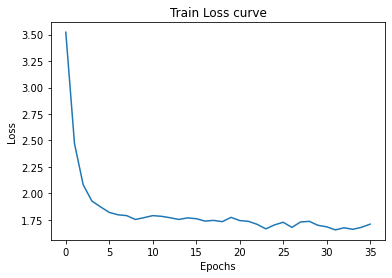

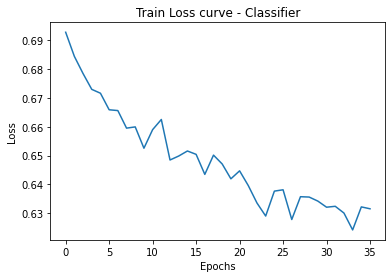

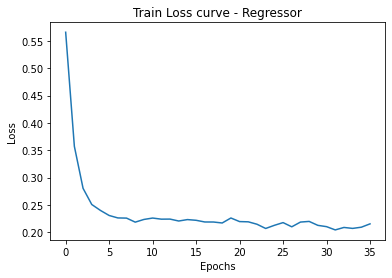

In [134]:
import matplotlib.pyplot as plt

train_losses = np.load("train_losses.npy")
# validation_losses = np.load("val_losses.npy")

plt.figure()
epochs = np.arange(36)
plt.plot(epochs, [loss[0] for loss in train_losses])
# plt.plot(epochs, [loss[0] for loss in validation_losses])
plt.title('Train Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, [loss[1] for loss in train_losses])
# plt.plot(epochs, [loss[0] for loss in validation_losses])
plt.title('Train Loss curve - Classifier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, [loss[2] for loss in train_losses])
# plt.plot(epochs, [loss[0] for loss in validation_losses])
plt.title('Train Loss curve - Regressor')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
 

###Point-wise Accuracy

In [141]:
model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))
model_path = '/content/rpnfinal.pth'
model.load_state_dict(torch.load(model_path)) 
model.eval()

conf_thresh = 0.5
anchors_shape = model.get_anchors().shape              
accuracy_list = []
img_count = 0
COCODataLoader.setup()
for batch in COCODataLoader.predict_dataloader():
  img, label, mask, bbox, indices = batch

  pred_clas, pred_coord = model.forward(img) 

  ground_clas_list, ground_coord_list = MultiApply(model.create_ground_truth, bbox, indices, [model.anchors_param['grid_size']]*batch_size, [model.anchors]*batch_size, [img.shape[2:4]]*batch_size)  

  ground_clas_list  = torch.stack(ground_clas_list,dim=0)
  
  positive_pred = (pred_clas > conf_thresh)
  ground_clas_list   = (ground_clas_list == 1)
  ground_clas_list = ground_clas_list.cpu()

  true_positives = torch.sum(positive_pred == ground_clas_list)

  accuracy = true_positives.item()/(img.shape[0] * anchors_shape[0] * anchors_shape[1])
  accuracy_list.append(accuracy)

accuracy = sum(accuracy_list)/len(accuracy_list)

print('Point-wise Accuracy: ', accuracy)

Point-wise Accuracy:  0.6123633006035492


###Top 20 proposals

######### TOP 20 proposals #################


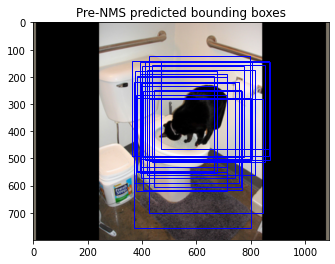

######### TOP 20 proposals #################


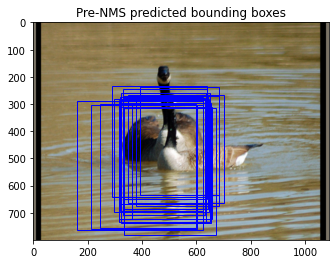

######### TOP 20 proposals #################


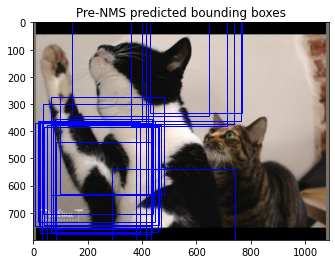

######### TOP 20 proposals #################


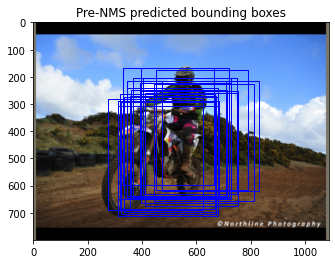

######### TOP 20 proposals #################


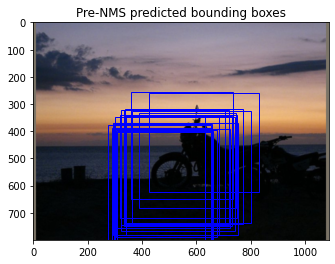

######### TOP 20 proposals #################


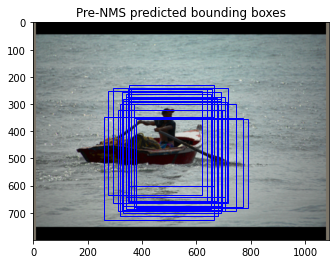

In [ ]:
model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))
model_path = '/content/rpnfinal.pth'
model.load_state_dict(torch.load(model_path)) 
model.eval()

import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

image_size = (800, 1088)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for j, idx in enumerate([0, 1, 3, 5, 10, 25]):
  images, labels, masks, bboxes, indices = COCOdata.__getitem__(idx)
  
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  x = images * STD[:, None, None] + MEAN[:, None, None]

  images = images.unsqueeze(0)

  pred_clas, pred_coord = model.forward(images)
  print('######### TOP 20 proposals #################')
  model.postprocess(x, pred_clas,pred_coord, IOU_thresh=0.5, keep_num_preNMS=20, keep_num_postNMS=0)
  # print('###########################################')




###Post Processing and NMS

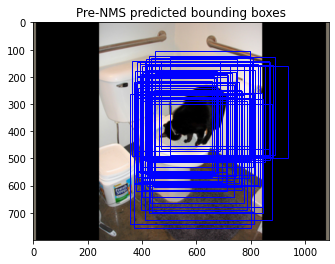

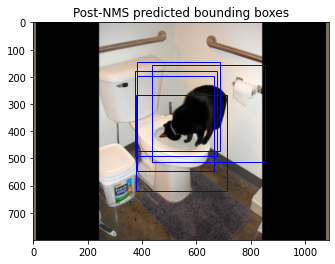

###########################################


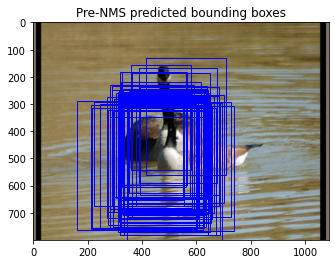

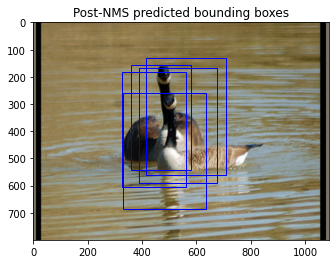

###########################################


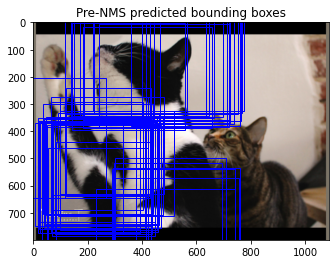

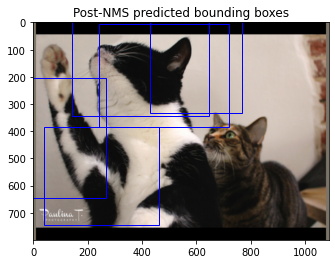

###########################################


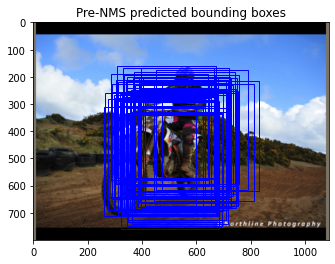

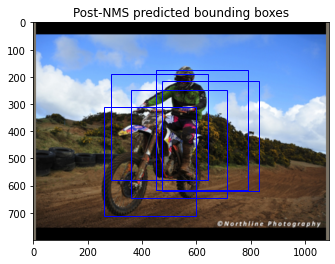

###########################################


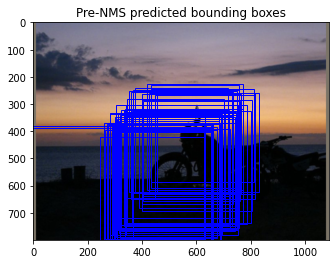

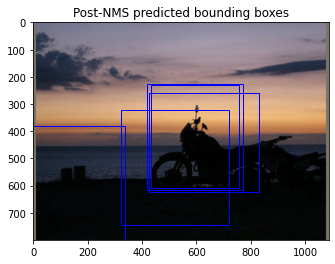

###########################################


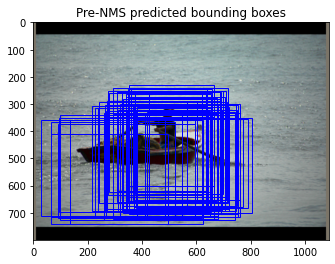

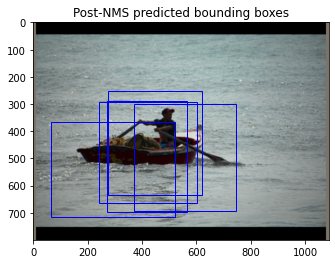

###########################################


In [ ]:
model = RPNHead(anchors_param=dict(ratio=1,scale=400, grid_size=(50, 68), stride=16))
model_path = '/content/rpnfinal.pth'
model.load_state_dict(torch.load(model_path)) 
model.eval()

import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

image_size = (800, 1088)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for j, idx in enumerate([0, 1, 3, 5, 10, 25]):
  images, labels, masks, bboxes, indices = COCOdata.__getitem__(idx)
  
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  x = images * STD[:, None, None] + MEAN[:, None, None]

  images = images.unsqueeze(0)

  pred_clas, pred_coord = model.forward(images)

  nms_clas_list, nms_prebox_list = model.postprocess(x, pred_clas,pred_coord, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=5)
  print('###########################################')

